# Pre-generate Noise Stimuli For Dynamic Noise Masking Studies

The goal of this notebook is to pre-generate the noise stimuli so that:
- We save an image MxN, where M is the size of 1 strip (column) of noise corresponding to the image size, and N is the number of frames of the longest stimulus duration condition
- We will need 35 images (which should cover an entire run of the condition) for each condition

- When loaded in we pull in the frames in reverse, so the starting frame can always be different between the stimulus durations

Note:
- Make sure it is saved at the highest contrast
- Test that generating it dynamically and generating it from the pre-generated image give the same result 


### Generating the Noise Stimulus

In [1]:
# import libraries and functions
import os  # handy system and path functions
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Baldwin Vision Lab custom code
#from src.custom.bvl_psychopy import make_high_bit_depth_vpixx_window, show_cross, show_str
from src.custom.bvl          import dB_to_lin, gauss_image_envelope, rcos_image_envelope, get_ideal_observer_response_choice_in_dynamic_noise, two_dimensional_noise_generator
from src.custom.expfunc      import grating_in_dynamic_noise_strip_stimulus, load_stimulus_properties, random_seed_gen, gen_frame_images

In [2]:
def reload_exp_properties(dBRMS_noise_contrast, temporal_plateau_width_secs, spatial_noise, temporal_noise, settings_filepath):
    expInfo = {
           'temporalPlateauWidthSeconds' : temporal_plateau_width_secs, 
           'dBRMSNoiseContrast' : dBRMS_noise_contrast,
           'spatial_noise_type': spatial_noise,
           'temporal_noise_type': temporal_noise,
           'gratingType' : 'sin'
           }
    stimulus_properties = load_stimulus_properties(settings_filepath, expInfo)
    noise_properties = {'spatial_noise_type':stimulus_properties['spatial_noise_type'], 'temporal_noise_type': stimulus_properties['temporal_noise_type'] ,'pixelScale':2}

    return stimulus_properties, noise_properties

def generate_noise(dBRMS_noise_contrast, temporal_plateau_width_secs, constant_to_add_to_seed, spatial_noise_condition, temporal_noise_condition, settings_filepath):
    stimulus_properties, noise_properties =  reload_exp_properties(dBRMS_noise_contrast, temporal_plateau_width_secs, spatial_noise_condition, temporal_noise_condition, settings_filepath) # reload settings 
    random_seed = random_seed_gen(constant_to_add_to_seed) # generate random seed
    noise_image = two_dimensional_noise_generator(stimulus_properties['imSizePix'], noise_properties, stimulus_properties['temporalPresentationTimeFrames'], random_seed) # TODO: check where temporal plateau width plays a role

    return random_seed, noise_image, stimulus_properties

In [3]:
# Initalize File Paths
stimuli_filepath = f'..{os.sep}..{os.sep}src{os.sep}stimuli'
if not os.path.exists(stimuli_filepath):
        os.makedirs(stimuli_filepath)

# Stimulus File Paths
settings_filepath   = f'..{os.sep}..{os.sep}src{os.sep}settings{os.sep}noise_masking.csv'

# Initalize pandas dataframe
record_df_cols = ['experiment', 'spatial_noise', 'temporal_noise', 'temporal_plateau_width_secs', 'temporal_plateau_width_frames', 'stimulus_duration_frames', 'frame_rate', 'dB_contrast', 'random_seed', 'stimuli_num', 'stimuli_filename', 'dB_noise_contrast', 'target']


In [4]:
# Initalize variables
NUM_TRIALS = 50
constant_to_add_to_random_seed = 2
TEMPORAL_PLATEAU_WIDTH_SECS = 5.0
DBRMS_NOISE_CONTRAST = 0

experiment_labels = ["dynamic-noise-detection"] # , "dynamic-noise-masking" # TODO: put this back in for testing
spatial_noise_conditions = ["pink"]
temporal_noise_conditions = ["constant", "pink", "white"]

for experiment in experiment_labels:
    experiment_df = pd.DataFrame(columns=record_df_cols) # Initalize the record dataframe
    experiment_filepath = f'{stimuli_filepath}{os.sep}{experiment}{os.sep}'
    if not os.path.exists(experiment_filepath):
        os.makedirs(experiment_filepath)

    for spatial_noise_condition in spatial_noise_conditions:
        for temporal_noise_condition in temporal_noise_conditions:
            if experiment == "dynamic-noise-masking":
                NUM_TRIALS*=2
            for iTrial in range(0, NUM_TRIALS):
                constant_to_add_to_random_seed+=(iTrial+1) #this will help avoid the random seed being the same each time
                # generate the noise image
                random_seed, noise_image, stimulus_properties = generate_noise(DBRMS_NOISE_CONTRAST, TEMPORAL_PLATEAU_WIDTH_SECS, constant_to_add_to_random_seed, spatial_noise_condition, temporal_noise_condition, settings_filepath)
                stimulus_filename = f"{spatial_noise_condition}_{temporal_noise_condition}_{iTrial}"
                condition_df = pd.DataFrame.from_dict({'experiment': [experiment],
                            'spatial_noise': [spatial_noise_condition],
                            'temporal_noise': [temporal_noise_condition], 
                            'temporal_plateau_width_secs': [TEMPORAL_PLATEAU_WIDTH_SECS],
                            'temporal_plateau_width_frames': [stimulus_properties['temporalPlateauWidthFrames']],
                            'stimulus_duration_frames': [stimulus_properties['temporalPresentationTimeFrames']],
                            'frame_rate': [stimulus_properties['screenFrameRate']],
                            'dB_noise_contrast': [DBRMS_NOISE_CONTRAST],
                            'random_seed': [random_seed],
                            'stimuli_num': [iTrial+1],
                            'stimuli_filename': stimulus_filename})
                # add condition to the experiment dataframe
                experiment_df = experiment_df.append(condition_df)
                # save data in the corresponding folder
                with open(f'{experiment_filepath}{stimulus_filename}.npy', 'wb') as f:
                    np.save(f, noise_image)

    # save experiment record dataframe 
    experiment_df.to_csv(f'{experiment_filepath}stimulus_record.csv')

                

In [5]:
experiment_filepath = f'{stimuli_filepath}{os.sep}{experiment}{os.sep}'
print(experiment_filepath)
allDataFiles   = os.listdir(experiment_filepath) 

print(allDataFiles)

../../src/stimuli/dynamic-noise-masking/
['pink_pink_134.npy', 'pink_pink_49.npy', 'pink_pink_165.npy', 'pink_white_300.npy', 'pink_white_133.npy', 'pink_white_209.npy', 'pink_white_2.npy', 'pink_white_90.npy', 'pink_white_59.npy', 'pink_pink_46.npy', 'pink_constant_0.npy', 'pink_white_313.npy', 'pink_pink_116.npy', 'pink_white_267.npy', 'pink_constant_30.npy', 'pink_white_155.npy', 'pink_white_323.npy', 'pink_pink_84.npy', 'pink_white_99.npy', 'pink_white_310.npy', 'pink_white_23.npy', 'pink_pink_124.npy', 'pink_constant_50.npy', 'pink_constant_14.npy', 'pink_pink_166.npy', 'pink_white_5.npy', 'pink_constant_73.npy', 'pink_pink_157.npy', 'pink_white_295.npy', 'pink_pink_18.npy', 'pink_pink_7.npy', 'pink_pink_135.npy', 'pink_pink_25.npy', 'pink_pink_5.npy', 'pink_constant_40.npy', 'pink_constant_63.npy', 'pink_white_398.npy', 'pink_white_279.npy', 'pink_pink_66.npy', 'pink_constant_10.npy', 'pink_pink_103.npy', 'pink_white_123.npy', 'pink_white_370.npy', 'pink_pink_37.npy', 'pink_pink_

### Re-loading and Generating the Full Stimulus

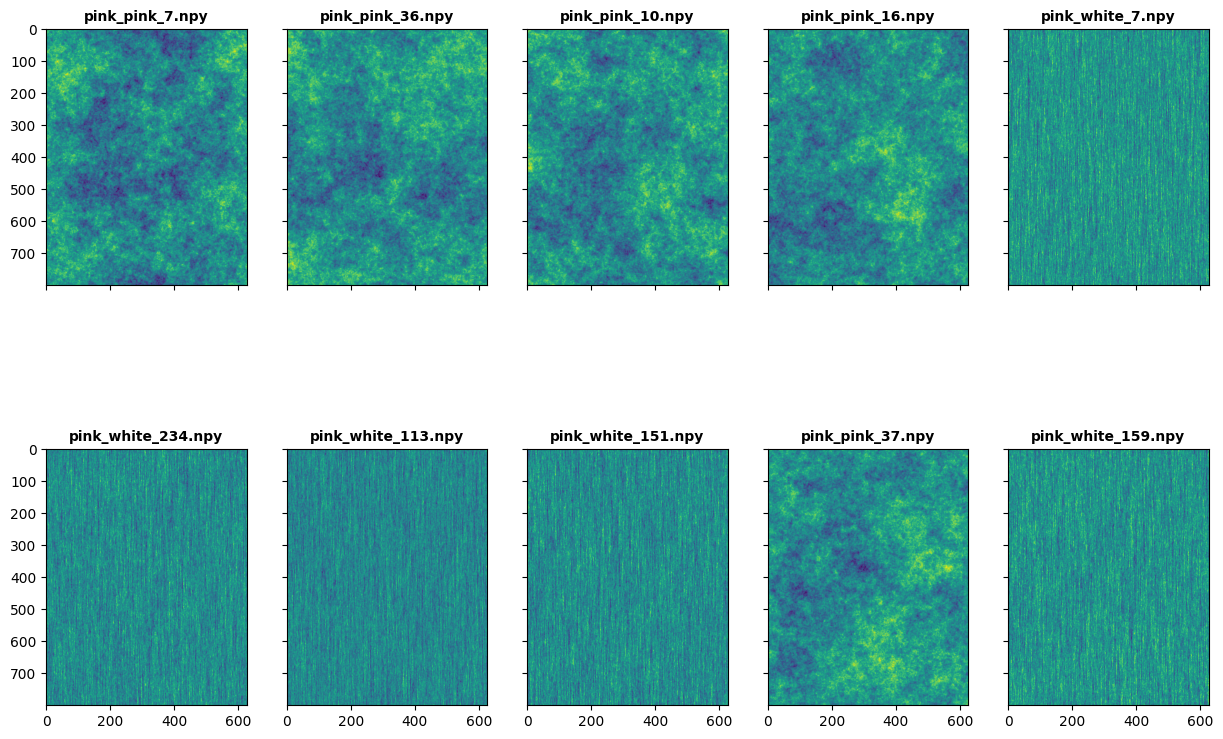

In [6]:
# Load in noise binary to check visually that the files look as expected,
# from the experiment folder, choose some random images and plot them 
SAMPLES_TO_VIEW = 5
fig,axes = plt.subplots(nrows=2,ncols=SAMPLES_TO_VIEW,figsize=(15,10),sharex=True,sharey=True)

for i_experiment, experiment in enumerate(experiment_labels):
    experiment_filepath = f'{stimuli_filepath}{os.sep}{experiment}{os.sep}'
    allDataFiles   = os.listdir(experiment_filepath)
    np.random.shuffle(allDataFiles) 

    for i_sample in range(0, SAMPLES_TO_VIEW):
        ax = axes[i_experiment, i_sample]
        ax.set_title(f"{allDataFiles[i_sample]}", fontsize=10, fontweight='bold')

        image = np.load(f'{experiment_filepath}{allDataFiles[i_sample]}')
        ax.imshow(image)


index=168, seed=1706816554, file=pink_pink_68
True


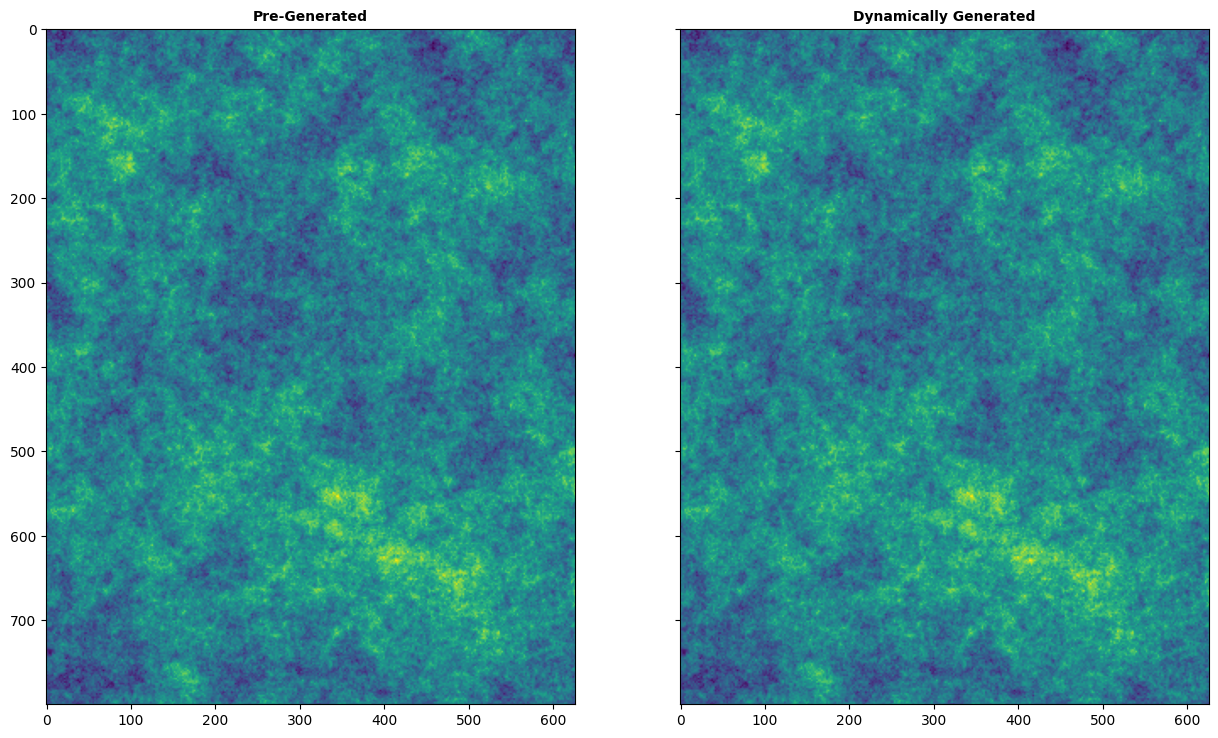

In [7]:
# Load the csv record file
experiment_filepath
stimulus_record = pd.read_csv(f"{experiment_filepath}stimulus_record.csv")

stimulus_record.head()

# Select a random stimulus
rand_stimulus_ind = np.random.randint(0, len(stimulus_record))
rand_stimulus_seed = stimulus_record["random_seed"].iloc[rand_stimulus_ind]
rand_stimulus_filename = stimulus_record["stimuli_filename"].iloc[rand_stimulus_ind]

print(f"index={rand_stimulus_ind}, seed={rand_stimulus_seed}, file={rand_stimulus_filename}")

# Generate stimulus dynamically using pre-generated noise 
loaded_stimulus_image = np.load(f'{experiment_filepath}{rand_stimulus_filename}.npy')

# Generate stimulus (noise + grating) dynamically using that seed
noise_properties = {'spatial_noise_type': rand_stimulus_filename.split("_")[0], 'temporal_noise_type': rand_stimulus_filename.split("_")[1] ,'pixelScale':2}
dynamic_stimulus_image = two_dimensional_noise_generator(stimulus_properties['imSizePix'], noise_properties, int(stimulus_record['stimulus_duration_frames'].iloc[rand_stimulus_ind]), rand_stimulus_seed) 

# Visually compare stimuli 
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,10),sharex=True,sharey=True)
ax = axes[0]
ax.set_title("Pre-Generated", fontsize=10, fontweight='bold')
ax.imshow(loaded_stimulus_image)

ax = axes[1]
ax.set_title("Dynamically Generated", fontsize=10, fontweight='bold')
ax.imshow(dynamic_stimulus_image)

# Mathematically compare stimuli
print((dynamic_stimulus_image == loaded_stimulus_image).all())


# Loading in Noise Images

In [8]:
# expInfo = {'temporal_noise_type':"white",
#            'participant': 'test'}
# stimulus_properties['temporalPresentationTimeFrames'] = 50

# # Load in noise stimulus csv
# participant_log_filepath = f"..{os.sep}..{os.sep}participant_log{os.sep}{experiment}{os.sep}{expInfo['temporal_noise_type']}{os.sep}{expInfo['participant']}.csv"
# stimuli_filepath = f'..{os.sep}..{os.sep}src{os.sep}stimuli'
# experiment_filepath = f'{stimuli_filepath}{os.sep}{experiment}{os.sep}'

# if os.path.exists(f"{participant_log_filepath}"):
#     print(f"Logfile exists, loading it!")
#     noise_stimuli_df = pd.read_csv(f"{participant_log_filepath}")
# else:
#     print(f"Logfile does not exist, creating a new one!")
#     os.makedirs(participant_log_filepath)
#     all_stimuli_df = pd.read_csv(f"{experiment_filepath}stimulus_record.csv")

#     # Grab a sub-set of stimuli that match the experiment and noise
#     noise_stimuli_df = all_stimuli_df[all_stimuli_df["temporal_noise"] == expInfo['temporal_noise_type']].reset_index(drop=True)
#     # Shuffle the pandas dataframe 
#     noise_stimuli_df = noise_stimuli_df.sample(frac=1).reset_index(drop=False)
#     # Save this pandas dataframe as a csv file 
#     noise_stimuli_df.to_csv(f"{participant_log_filepath}{os.sep}{expInfo['participant']}.csv")
    

# # Slice the noise image to match the number of frames needed in this condition
# noise_images = []
# for i_stimulus in range(0, len(noise_stimuli_df)):
#     noise_image = np.load(f'{experiment_filepath}{noise_stimuli_df["stimuli_filename"].iloc[i_stimulus]}.npy')
#     start_ind = noise_image.shape[1]-stimulus_properties['temporalPresentationTimeFrames']
#     end_ind = noise_image.shape[1]+1
#     noise_image = noise_image[:,start_ind:end_ind]
#     noise_images.append(noise_image)